In [26]:
#from muxcnn.utils import *
from muxcnn.hecnn_par import *
from icecream import ic
import torch
import torch.nn.functional as F

## Torch model

In [27]:
def load_params(model, fn_param, device):
    trained_param = torch.load(fn_param, map_location = torch.device(device))
    trained_param = {key : value.cpu()   for key,value in trained_param.items()}
    params_np     = {key : value.numpy() for key,value in trained_param.items()}
    model.load_state_dict(trained_param)

def load_img(fname, hi=None, wi=None):
    image = cv2.imread(fname)
    if hi is not None and wi is not None:
        image = cv2.resize(image,(hi,wi))
    img = get_channel_first(image)
    img = torch.tensor(img).unsqueeze(0)
    return img.type(torch.FloatTensor)

In [28]:
from muxcnn.models.ResNet20 import ResNet, BasicBlock

activation = F.relu

model = ResNet(BasicBlock,[1,1,1])
load_params(model, fn_param="./ResNet8.pt",device='cpu')

In [29]:
img_tensor = load_img("./cute.jpg", hi=32, wi=32)

torch.Size([1, 16, 32, 32])


Text(0.5, 1.0, 'After bn1')

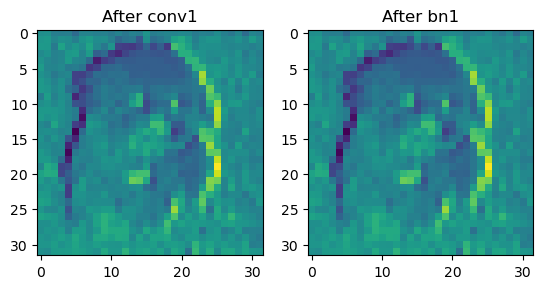

In [30]:
#img_tensor = convert_tensor(img)
res1 = model.conv1(img_tensor)
print(res1.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(res1[0,0,:,:].detach().numpy())
axs[0].set_title("After conv1")

res2 = model.bn1(res1)
axs[1].imshow(res2[0,0,:,:].detach().numpy())
axs[1].set_title("After bn1")

In [31]:
model.layer1[0]

BasicBlock(
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (shortcut): Sequential()
)

In [32]:
res1 = model.conv1(img_tensor)
res1b = model.bn1(res1)

In [33]:
model.bn1.weight

Parameter containing:
tensor([0.6424, 0.5615, 1.0674, 0.7741, 0.9472, 0.8808, 1.0866, 1.0890, 0.4921,
        0.8071, 0.5211, 1.0955, 1.0757, 0.6055, 0.4599, 0.5332],
       requires_grad=True)

In [34]:

res2 = model.layer1[0].conv1(res1)
res3 = model.layer1[0].conv2(res2)
res4 = model.layer2[0].conv1(res3)
res5 = model.layer2[0].conv2(res4)
res6 = model.layer3[0].conv1(res5)
res7 = model.layer3[0].conv2(res6)

# FHE-frinedly model

In [36]:
imgl = get_channel_last(img_tensor[0].detach().numpy())
ki = 1
hi, wi, ch = imgl.shape

U, ins, outs = get_conv_params(model.conv1, {'k':ki, 'h':hi, 'w':wi})
ct_a = MultParPack(imgl, ins)
out, un1 = forward_conv_par(model.conv1, ct_a, ins)

U, ins, outs = get_conv_params(model.layer1[0].conv1, outs)
out, un2 = forward_conv_par(model.layer1[0].conv1, out,  ins)

U, ins, outs = get_conv_params(model.layer1[0].conv2, outs)
out, un3 = forward_conv_par(model.layer1[0].conv2, out,  ins)

U, ins, outs = get_conv_params(model.layer2[0].conv1, outs)
out, un4 = forward_conv_par(model.layer2[0].conv1, out, ins)

U, ins, outs = get_conv_params(model.layer2[0].conv2, outs)
out, un5 = forward_conv_par(model.layer2[0].conv2, out, ins)

U, ins, outs = get_conv_params(model.layer3[0].conv1, outs)
out, un6 = forward_conv_par(model.layer3[0].conv1, out, ins)

U, ins, outs = get_conv_params(model.layer3[0].conv2, outs)
out, un7 = forward_conv_par(model.layer3[0].conv2, out, ins)

[MultParConv] (hi,wi,ci,ki,ti,pi) =(32,32, 3, 1, 3,  8)
[MultParConv] (ho,wo,co,ko,to,po) =(32,32,16, 1,16,  2)
[MultParConv] q = 2
[MultParConv] (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[MultParConv] (ho,wo,co,ko,to,po) =(32,32,16, 1,16,  2)
[MultParConv] q = 8
[MultParConv] (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[MultParConv] (ho,wo,co,ko,to,po) =(32,32,16, 1,16,  2)
[MultParConv] q = 8
[MultParConv] (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[MultParConv] (ho,wo,co,ko,to,po) =(16,16,32, 2, 8,  4)
[MultParConv] q = 16
[MultParConv] (hi,wi,ci,ki,ti,pi) =(16,16,32, 2, 8,  4)
[MultParConv] (ho,wo,co,ko,to,po) =(16,16,32, 2, 8,  4)
[MultParConv] q = 8
[MultParConv] (hi,wi,ci,ki,ti,pi) =(16,16,32, 2, 8,  4)
[MultParConv] (ho,wo,co,ko,to,po) =( 8, 8,64, 4, 4,  8)
[MultParConv] q = 16
[MultParConv] (hi,wi,ci,ki,ti,pi) =( 8, 8,64, 4, 4,  8)
[MultParConv] (ho,wo,co,ko,to,po) =( 8, 8,64, 4, 4,  8)
[MultParConv] q = 8


In [37]:
def compare(tout, fout, ch=0, fn=None, err_mag= 1e-5):
    tt = tout.detach().numpy()[0,ch,:,:]
    ff = fout[ch,:,:]
    
    fig, axs = plt.subplots(2,2)
    vmin = tt.min()
    vmax = tt.max()
    axs[0,0].imshow(tt, vmin=vmin, vmax=vmax)
    axs[0,0].set_title("torch")
    axs[0,1].imshow(ff, vmin=vmin, vmax=vmax)
    axs[0,1].set_title("fhe")
    axs[1,0].imshow(tt-ff, vmin=vmin*err_mag, vmax=vmax*err_mag)
    axs[1,0].set_title(f"diff (min,max)*{err_mag:.2g}")
    plt.tight_layout()
    if fn is not None:
        plt.savefig(fn.replace(".png", f"_{ch}.png"))
        plt.close()
    

In [38]:
compare(res6, un6, ch=0, fn="layer6.png")
compare(res6, un6, ch=1, fn="layer6.png")
compare(res6, un6, ch=4, fn="layer6.png")
compare(res6, un6, ch=7, fn="layer6.png")

In [39]:
compare(res1, un1, ch=0, fn="layer1.png")
compare(res2, un2, ch=0, fn="layer2.png")
compare(res3, un3, ch=0, fn="layer3.png")
compare(res4, un4, ch=0, fn="layer4.png")
compare(res5, un5, ch=0, fn="layer5.png")
compare(res6, un6, ch=0, fn="layer6.png")
compare(res7, un7, ch=0, fn="layer7.png")